#Introduction to GNNs on Simple Graphs

**Objective**: Demonstrate the fundamentals of a GNN by applying it to a toy graph dataset (e.g., Zachary’s Karate Club or a small social network).

**Steps in the Colab:**

1. Generate or load a small graph dataset using a library like NetworkX or PyTorch Geometric.
2. Visualize the graph to show nodes, edges, and features.
3. Implement a simple message-passing scheme to aggregate neighbor features for node classification.
4. Train a basic GNN model
5. Visualize node embeddings before and after training.

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 45.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Import necessary libraries
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

**Step 2: Define a Simple GNN Model**



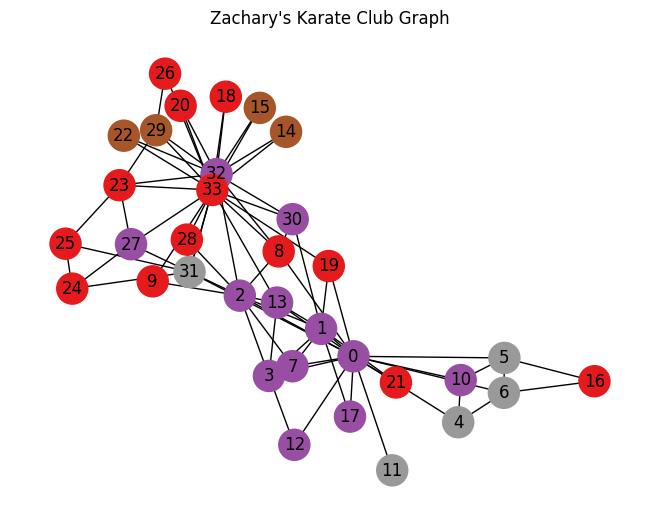

In [ ]:
# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]  # Load the single graph in the dataset

# Visualize the graph using NetworkX
def visualize_graph(data):
    G = nx.Graph()
    for edge in data.edge_index.T:
        G.add_edge(edge[0].item(), edge[1].item())
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=data.y.numpy(), cmap=plt.cm.Set1, node_size=500)
    plt.title("Zachary's Karate Club Graph")
    plt.show()

visualize_graph(data)


**GNN Parameters:**

```
input_dim: The size of the input features for each node.
hidden_dim: The number of hidden units in the first layer.
output_dim: The size of the output features for each node.
```

Layers:

```
self.conv1: A Graph Convolutional Network (GCNConv) layer that
transforms the node features from input_dim to hidden_dim.
self.conv2: Another GCN layer that transforms the node features
from hidden_dim to output_dim.
```


In [ ]:
# Define a simple GNN model using PyTorch Geometric
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)  # First GCN layer
        self.conv2 = GCNConv(hidden_dim, output_dim)  # Second GCN layer

    def forward(self, x, edge_index):
        # First layer: message passing and activation
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        # Second layer: message passing
        x = self.conv2(x, edge_index)
        return x


**Train the GNN**

# Training Loop Explanation

The training loop is the core of the neural network training process. Here's how it works:

1. `model.train()` sets the model to training mode, which enables important features like dropout and batch normalization.

2. Each epoch consists of these key steps:
  - `optimizer.zero_grad()` clears any existing gradients from previous iterations
  - Forward pass: `model(data.x, data.edge_index)` processes node features and edge connections
  - Loss calculation: compares predictions with true labels using CrossEntropyLoss
  - `loss.backward()` computes gradients through backpropagation
  - `optimizer.step()` updates model parameters using the Adam optimizer

3. Every 20 epochs, we monitor progress by:
  - Getting predictions using `argmax` on model outputs
  - Calculating training accuracy by comparing predictions with true labels
  - Printing the current epoch number, loss value, and training accuracy

This process repeats for 200 epochs, gradually improving the model's performance through iterative optimization.

In [ ]:
# Prepare the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Initialize the model, optimizer, and loss function
model = GNN(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train_model(data, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)  # Forward pass
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss
        loss.backward()
        optimizer.step()

        # Print training progress
        if (epoch + 1) % 20 == 0 or epoch == 0:
            pred = out.argmax(dim=1)
            acc = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
            print(f"Epoch {epoch+1:03d}, Loss: {loss:.4f}, Train Accuracy: {acc:.4f}")

train_model(data)


Epoch 001, Loss: 1.3600, Train Accuracy: 0.2500
Epoch 020, Loss: 0.9049, Train Accuracy: 0.7500
Epoch 040, Loss: 0.3982, Train Accuracy: 1.0000
Epoch 060, Loss: 0.0998, Train Accuracy: 1.0000
Epoch 080, Loss: 0.0313, Train Accuracy: 1.0000
Epoch 100, Loss: 0.0151, Train Accuracy: 1.0000
Epoch 120, Loss: 0.0093, Train Accuracy: 1.0000
Epoch 140, Loss: 0.0064, Train Accuracy: 1.0000
Epoch 160, Loss: 0.0047, Train Accuracy: 1.0000
Epoch 180, Loss: 0.0037, Train Accuracy: 1.0000
Epoch 200, Loss: 0.0029, Train Accuracy: 1.0000


# Dataset Splitting and Model Evaluation

The code handles two crucial aspects of machine learning: dataset splitting and model evaluation.

## Train-Test Split
First, we create binary masks to separate our data into training and testing sets:
- `train_mask`: A boolean tensor marking the first 20 nodes as training data (True)
- `test_mask`: A boolean tensor marking the remaining nodes as test data (True)
This split allows us to evaluate our model's performance on unseen data.

## Model Evaluation Function
The `evaluate_model()` function assesses model performance on the test set:
1. `model.eval()` switches the model to evaluation mode (disabling dropout, etc.)
2. `torch.no_grad()` disables gradient computation for efficiency
3. Model predictions are generated and compared with true labels
4. Test accuracy is calculated as the proportion of correct predictions
5. Final predictions are returned as a NumPy array for further analysis

This evaluation process helps us understand how well our model generalizes to new, unseen data.

In [ ]:

# Create train and test masks
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

# Assign train and test nodes (e.g., first 34 nodes for training, remaining for testing)
data.train_mask[:20] = True  # Use the first 20 nodes for training
data.test_mask[20:] = True   # Use the remaining nodes for testing


# Evaluate the model on the test set
def evaluate_model(data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        print(f"Test Accuracy: {acc:.4f}")
    return pred.cpu().numpy()

pred = evaluate_model(data)


Test Accuracy: 0.7857


# Node Embedding Visualization

This code visualizes how the Graph Neural Network (GNN) transforms node features during training using dimensionality reduction and scatter plots.

## The Visualization Process
1. **Dimensionality Reduction**
  - Uses PCA (Principal Component Analysis) to reduce high-dimensional embeddings to 2D
  - This allows us to visualize complex node features in a 2D plot

2. **Visualization Function**
  - Takes the graph data and node embeddings as input
  - Reduces dimensions using PCA
  - Creates a scatter plot where:
    * Each point represents a node
    * Colors indicate node classes
    * The colorbar shows the class mapping
  
3. **Comparison Plots**
  - First plot: Original node features before GNN processing
  - Second plot: Learned node embeddings after GNN training
  - This comparison helps us understand how the GNN has learned to reorganize nodes in the feature space to make classification easier

The side-by-side visualization helps demonstrate if the model has successfully learned to cluster nodes of the same class together.

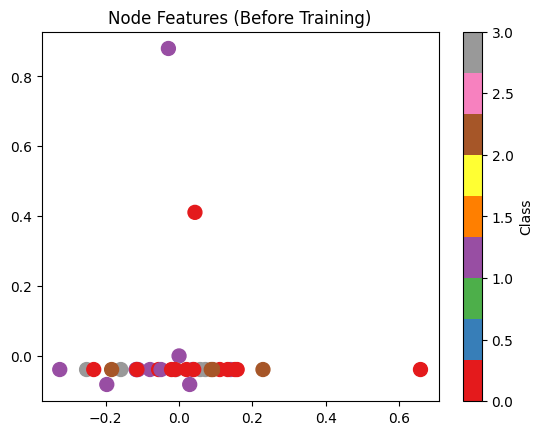

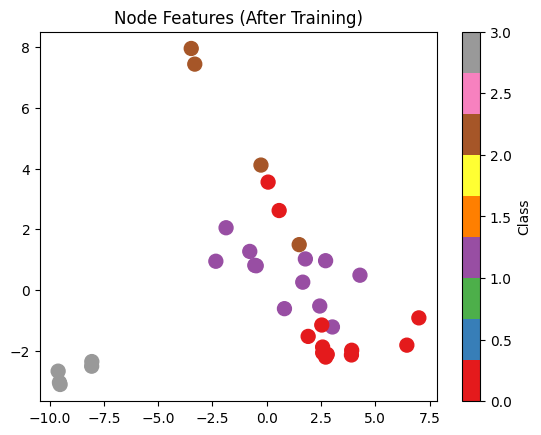

In [ ]:
# Visualize the node embeddings before and after training
from sklearn.decomposition import PCA

def visualize_embeddings(data, embeddings, title):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings.detach().cpu().numpy())
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap=plt.cm.Set1, s=100)
    plt.title(title)
    plt.colorbar(label="Class")
    plt.show()

# Visualize before and after training
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

visualize_embeddings(data, data.x, "Node Features (Before Training)")
visualize_embeddings(data, embeddings, "Node Features (After Training)")


#Node Classification Using Graph Attention Networks (GAT)

**Objective**: Train a GAT to classify nodes in a graph while emphasizing the importance of attention mechanisms.
1. Load a benchmark dataset like Cora or Citeseer (citation networks).
2. Visualize the node feature matrix and adjacency matrix.
3. Build a GAT model using PyTorch Geometric’s GATConv layer.
4. Visualize attention scores assigned to neighbors during message passing.
5. Train the model for node classification and evaluate performance (e.g., accuracy, AUC-ROC).

# Graph Attention Network (GAT) Implementation for Citation Network Analysis

This code implements a Graph Attention Network to analyze the Cora citation network dataset. Here's a breakdown of each major component:

## Dataset and Setup
- Uses the Cora dataset: a citation network where nodes are academic papers and edges represent citations
- Each node (paper) has text-based features and belongs to one of several research categories
- PyTorch Geometric's Planetoid class handles the data loading and preprocessing

## Network Visualization
- Converts the PyTorch Geometric graph to NetworkX format for visualization
- Creates a spring layout visualization where:
 * Nodes represent papers
 * Edges represent citations
 * Colors indicate paper categories
 * Uses force-directed layout for clear structure visualization

## GAT Model Architecture
- Implements a two-layer Graph Attention Network:
 1. First layer: Multi-head attention (8 heads) with ReLU activation
 2. Second layer: Single-head attention for final classification
- Uses attention mechanisms to weigh neighbor importance differently for each node
- Combines features from multiple attention heads to capture different aspects of node relationships

## Training and Evaluation
- Uses Adam optimizer with weight decay for regularization
- CrossEntropy loss for multi-class classification
- Monitors both accuracy and AUC-ROC score on test set
- Implements early progress monitoring every 20 epochs

This implementation demonstrates how Graph Attention Networks can effectively learn from both node features and graph structure for node classification tasks.

Processing...
Done!


Dataset: Cora
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7


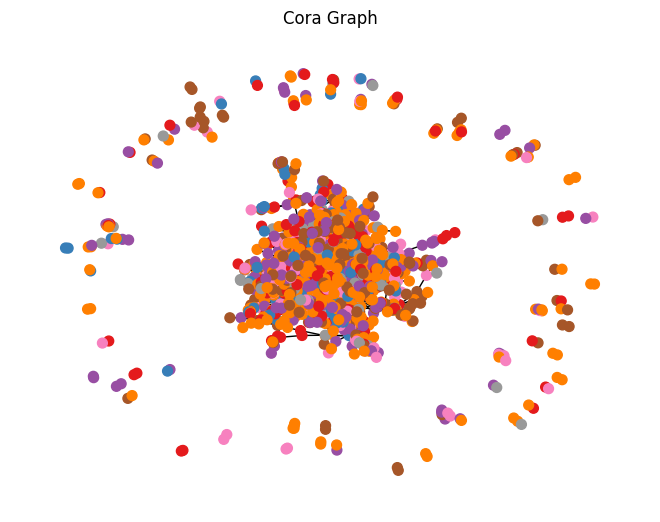

Epoch 20/200, Loss: 0.0422, Train Accuracy: 1.0000
Epoch 40/200, Loss: 0.0039, Train Accuracy: 1.0000
Epoch 60/200, Loss: 0.0049, Train Accuracy: 1.0000
Epoch 80/200, Loss: 0.0079, Train Accuracy: 1.0000
Epoch 100/200, Loss: 0.0073, Train Accuracy: 1.0000
Epoch 120/200, Loss: 0.0064, Train Accuracy: 1.0000
Epoch 140/200, Loss: 0.0060, Train Accuracy: 1.0000
Epoch 160/200, Loss: 0.0055, Train Accuracy: 1.0000
Epoch 180/200, Loss: 0.0051, Train Accuracy: 1.0000
Epoch 200/200, Loss: 0.0048, Train Accuracy: 1.0000
Test Accuracy: 0.7670
Test AUC-ROC: 0.9520


In [ ]:
# Import required libraries for graph neural networks, data handling, and visualization
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import networkx as nx

# Load the Cora dataset - a citation network where papers cite other papers
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]  # Get the first (and only) graph in the dataset

# Display basic statistics about the dataset
print(f"Dataset: {dataset.name}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features per node: {data.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")

def visualize_graph(data):
    # Convert PyTorch Geometric graph to NetworkX format for visualization
    G = nx.Graph()
    # Add edges one by one from the edge_index tensor
    for edge in data.edge_index.T:
        G.add_edge(edge[0].item(), edge[1].item())
    # Create a spring layout - nodes repel each other but edges pull them together
    pos = nx.spring_layout(G, seed=42)
    # Draw the graph with nodes colored by their class labels
    nx.draw(G, pos, with_labels=False, node_color=data.y.numpy(), cmap=plt.cm.Set1, node_size=50)
    plt.title("Cora Graph")
    plt.show()

visualize_graph(data)

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads):
        super(GAT, self).__init__()
        # First GAT layer with multiple attention heads to learn different aspects of the data
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        # Second GAT layer combines all attention heads for final prediction
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)  # Apply first attention layer
        x = torch.relu(x)             # Apply non-linearity
        x = self.gat2(x, edge_index)  # Apply second attention layer
        return x

# Set up device (GPU if available, else CPU) and initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT(
    input_dim=dataset.num_node_features,   # Number of features per node
    hidden_dim=8,                          # Size of hidden layer
    output_dim=dataset.num_classes,        # Number of classes to predict
    heads=8                                # Number of attention heads
).to(device)
data = data.to(device)  # Move data to same device as model

# Initialize optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()    # Standard loss for classification

def train(data, model, optimizer, criterion, epochs=200):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear gradients from previous iteration
        out = model(data.x, data.edge_index)  # Forward pass through the model
        # Compute loss only on training nodes (specified by train_mask)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()    # Compute gradients
        optimizer.step()   # Update model parameters

        # Print training progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            pred = out.argmax(dim=1)  # Get predicted classes
            # Calculate accuracy on training set
            train_acc = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}")

train(data, model, optimizer, criterion)

def evaluate(data, model):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for efficiency
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        # Calculate accuracy on test set
        test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
        print(f"Test Accuracy: {test_acc:.4f}")

        # Convert predictions and labels to appropriate format for AUC-ROC calculation
        one_hot_labels = torch.nn.functional.one_hot(data.y[data.test_mask], num_classes=dataset.num_classes).cpu()
        probabilities = torch.nn.functional.softmax(out[data.test_mask], dim=1).cpu()
        # Calculate AUC-ROC score for multi-class classification
        auc_roc = roc_auc_score(one_hot_labels.numpy(), probabilities.numpy(), multi_class="ovr")
        print(f"Test AUC-ROC: {auc_roc:.4f}")

evaluate(data, model)

# Attention Weight Visualization Function

This function visualizes the attention weights learned by the Graph Attention Network (GAT). Attention weights show how much importance the model assigns to different node connections when making predictions.

## Key Components
1. **Weight Extraction**:
   - Retrieves attention weights from the first GAT layer
   - Handles both single and multi-head attention architectures

2. **Data Processing**:
   - Converts PyTorch tensors to NumPy arrays
   - Flattens multi-dimensional attention weights for visualization

3. **Visualization**:
   - Creates a histogram showing the distribution of attention scores
   - Higher frequencies at certain weights indicate common patterns in how the model attends to different node connections
   - The spread of the distribution indicates the model's attention diversity

In [ ]:
def visualize_attention_scores(data, model):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for efficiency
        # Get attention weights from first GAT layer
        # return_attention_weights=True makes the layer return both output and attention weights
        output = model.gat1(data.x, data.edge_index, return_attention_weights=True)

        # Unpack the output tuple into edge indices and attention weights
        edge_index, attn_weights = output

        # Some GAT implementations return attention weights as a nested tuple
        # In this case, we need to extract the actual weights
        if isinstance(attn_weights, tuple):
            attn_weights = attn_weights[1]  # Get the actual attention weights from tuple

        # Move weights to CPU and convert to numpy for plotting
        attn_weights = attn_weights.cpu().numpy()

        # Create histogram visualization
        plt.hist(attn_weights, bins=30, alpha=0.7)  # 30 bins with slight transparency
        plt.title("Distribution of Attention Scores")
        plt.xlabel("Attention Weight")  # Weight magnitude
        plt.ylabel("Frequency")         # How often each weight appears
        plt.show()

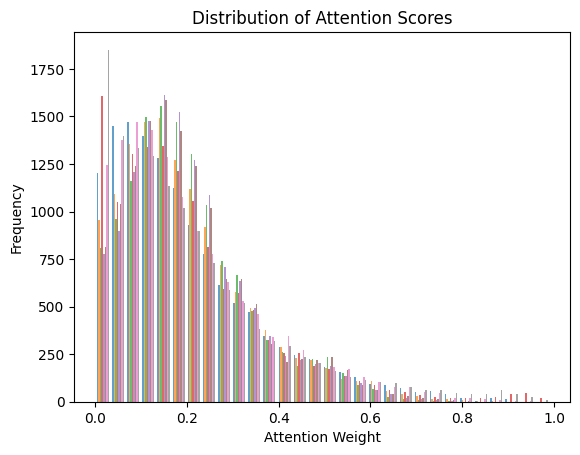

In [ ]:

# Call the attention visualization function
visualize_attention_scores(data, model)


#Graph Classification Using Graph Isomorphism Networks (GIN)

**Objective**: Use GIN to classify entire graphs (e.g., molecular graphs or datasets like MUTAG).
1. Load a graph classification dataset (e.g., MUTAG for molecules).
2. Preprocess the dataset to generate graph-level labels and features.
3. Build a GIN model using PyTorch Geometric’s GINConv layer.
4. Demonstrate how GIN aggregates and transforms features using its MLP-based architecture.
5. Train the model for graph classification and evaluate using metrics like F1-score and accuracy.

#MUTAG Dataset Overview
**What it is**:

MUTAG is a benchmark graph classification dataset consisting of 188 molecular graphs. Each graph represents a chemical compound.

**Node Features:**
Each node in the graph corresponds to an atom (e.g., carbon, oxygen, nitrogen).

Node features are one-hot encoded to represent the atom type (7 features in total, corresponding to the 7 unique atom types in the dataset).

**Edges:**
Edges represent chemical bonds between atoms.

**Graph Labels:**
Each graph is labeled as either mutagenic (class 1) or non-mutagenic (class 0), indicating whether the compound has a mutagenic effect on bacteria.


# Graph Isomorphism Network (GIN) for Molecular Classification

This code implements a Graph Isomorphism Network to classify molecules in the MUTAG dataset. The implementation includes:

## Data Processing
- Uses the MUTAG dataset: a collection of mutagenic aromatic and heteroaromatic nitro compounds
- Implements an 80/20 train/test split
- Batches graphs for efficient processing

## Model Architecture
- Three-layer GIN with skip connections
- Each GIN layer uses a Multi-Layer Perceptron (MLP)
- Global sum pooling for graph-level representation
- Final classification layer

## Training and Evaluation Pipeline
- Uses Adam optimizer with weight decay
- CrossEntropy loss for binary classification
- Evaluates using both accuracy and F1-score
- Implements batch processing for memory efficiency

This model demonstrates how GINs can effectively learn molecular graph structures for classification tasks.

In [ ]:
# Import required libraries for graph neural networks and data processing
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch.nn import Linear, ReLU, Sequential
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load MUTAG dataset - a collection of mutagenic molecule graphs
dataset = TUDataset(root=".", name="MUTAG")

# Display dataset information
print(f"Dataset: {dataset.name}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of node features: {dataset.num_node_features}")

# Create train/test split (80/20)
torch.manual_seed(42)  # For reproducible results
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        # Create three MLPs for the GIN layers
        # Each MLP has two linear layers with ReLU activation
        mlp1 = Sequential(
            Linear(input_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        mlp2 = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        mlp3 = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        # Initialize GIN convolution layers
        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.conv3 = GINConv(mlp3)
        # Final classification layer
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Apply GIN layers with ReLU activations
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)

        # Convert node-level features to graph-level features via sum pooling
        x = global_add_pool(x, batch)
        # Final classification
        return self.fc(x)

# Setup model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GIN(
    input_dim=dataset.num_node_features,
    hidden_dim=64,                    # Size of hidden layers
    output_dim=dataset.num_classes    # Number of classes to predict
).to(device)

# Initialize Adam optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train_model(train_loader, model, optimizer, criterion, epochs=50):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)           # Move batch to GPU if available
            optimizer.zero_grad()              # Clear gradients
            out = model(batch.x, batch.edge_index, batch.batch)  # Forward pass
            loss = criterion(out, batch.y)     # Compute loss
            loss.backward()                    # Compute gradients
            optimizer.step()                   # Update weights
            total_loss += loss.item()          # Accumulate loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

train_model(train_loader, model, optimizer, criterion)

def evaluate_model(loader, model):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():  # Disable gradient computation
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1)  # Get predicted classes
            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    # Calculate performance metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    print(f"Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

# Run evaluation on test set
evaluate_model(test_loader, model)

Processing...
Done!


Dataset: MUTAG
Number of graphs: 188
Number of classes: 2
Number of node features: 7
Epoch 1/50, Loss: 17.1379
Epoch 2/50, Loss: 3.3074
Epoch 3/50, Loss: 2.9882
Epoch 4/50, Loss: 3.0488
Epoch 5/50, Loss: 2.7571
Epoch 6/50, Loss: 2.5760
Epoch 7/50, Loss: 2.5788
Epoch 8/50, Loss: 2.6451
Epoch 9/50, Loss: 2.6192
Epoch 10/50, Loss: 2.4476
Epoch 11/50, Loss: 2.2181
Epoch 12/50, Loss: 2.1299
Epoch 13/50, Loss: 2.2214
Epoch 14/50, Loss: 2.4453
Epoch 15/50, Loss: 2.3433
Epoch 16/50, Loss: 2.2010
Epoch 17/50, Loss: 2.1998
Epoch 18/50, Loss: 2.3795
Epoch 19/50, Loss: 2.5661
Epoch 20/50, Loss: 2.2873
Epoch 21/50, Loss: 2.3477
Epoch 22/50, Loss: 2.1951
Epoch 23/50, Loss: 2.0257
Epoch 24/50, Loss: 2.1878
Epoch 25/50, Loss: 2.1393
Epoch 26/50, Loss: 1.9617
Epoch 27/50, Loss: 2.2224
Epoch 28/50, Loss: 2.0812
Epoch 29/50, Loss: 2.1465
Epoch 30/50, Loss: 2.1831
Epoch 31/50, Loss: 2.0543
Epoch 32/50, Loss: 2.1889
Epoch 33/50, Loss: 2.0368
Epoch 34/50, Loss: 2.0346
Epoch 35/50, Loss: 1.8801
Epoch 36/50, 

# Graph Isomorphism Network (GIN) for Molecular Classification

This code implements a Graph Isomorphism Network to classify molecules in the MUTAG dataset. The implementation includes:

## Data Processing
- Uses the MUTAG dataset: a collection of mutagenic aromatic and heteroaromatic nitro compounds
- Implements an 80/20 train/test split
- Batches graphs for efficient processing

## Model Architecture
- Three-layer GIN with skip connections
- Each GIN layer uses a Multi-Layer Perceptron (MLP)
- Global sum pooling for graph-level representation
- Final classification layer

## Training and Evaluation Pipeline
- Uses Adam optimizer with weight decay
- CrossEntropy loss for binary classification
- Evaluates using both accuracy and F1-score
- Implements batch processing for memory efficiency

This model demonstrates how GINs can effectively learn molecular graph structures for classification tasks.

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Dataset: QM9
Number of molecules (graphs): 130831
Number of atom features (node features): 11
Number of molecular properties (targets): 19

Example graph:
Node features (x): torch.Size([5, 11])
Edge indices (edge_index): torch.Size([2, 8])
Graph-level target (y): tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])

Training GIN...
Epoch 1, Train Loss: 1585699.7181, Val MAE: 255.9738, Val R2: -2.0184
Epoch 2, Train Loss: 424850.4701, Val MAE: 201.1947, Val R2: -78.1324
Epoch 3, Train Loss: 382061.8140, Val MAE: 225.0631, Val R2: -625.9297
Epoch 4, Train Loss: 323745.3493, Val MAE: 198.8103, Val R2: -33.1822
Epoch 5, Train Loss: 269282.4062, Val MAE: 248.5686, Val R2: -281.6557
Epoch 6, Train Loss: 269398.1299, Val MAE: 162.5749, Val R2: -6.6937
Epoch 7, Train Loss: 254782.5348

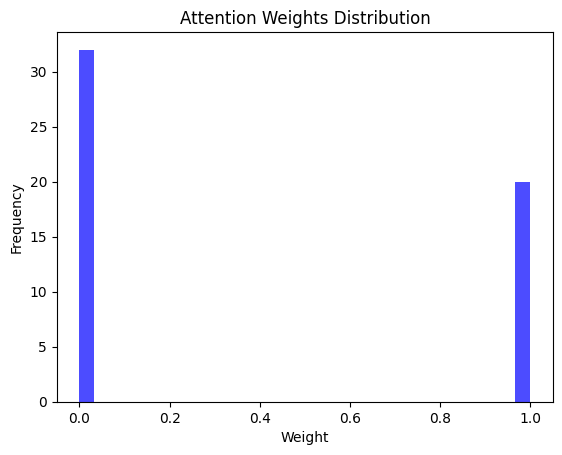

In [ ]:

# Import necessary libraries
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, GATConv, global_mean_pool
from torch.nn import Linear, Sequential, ReLU
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load and Explore the QM9 Dataset
# QM9 is a dataset of small molecules, widely used for molecular property prediction
dataset = QM9(root=".", pre_transform=None)

# Print dataset statistics
print(f"Dataset: QM9")
print(f"Number of molecules (graphs): {len(dataset)}")
print(f"Number of atom features (node features): {dataset.num_node_features}")
#print(f"Number of molecular properties (targets): {dataset.num_targets}")
print(f"Number of molecular properties (targets): {dataset[0].y.size(-1)}")


# Access the first graph in the dataset
graph = dataset[0]
print("\nExample graph:")
print(f"Node features (x): {graph.x.shape}")
print(f"Edge indices (edge_index): {graph.edge_index.shape}")
print(f"Graph-level target (y): {graph.y}")

# Step 2: Preprocess and Split the Dataset
# Use a subset for faster training and testing
subset_size = 5000  # Use only 5000 molecules for demonstration
dataset = dataset[:subset_size]

# Split into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching graphs
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 3: Define GIN and GAT Models
# GIN for molecular property prediction


class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        self.mlp1 = Sequential(
            Linear(input_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        self.mlp2 = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        self.mlp3 = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)  # Global pooling
        return self.fc(x)


# GAT for identifying important nodes/edges
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4)
        self.gat2 = GATConv(hidden_dim * 4, output_dim, heads=1, concat=False)

    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.gat2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global pooling
        return x

# Step 4: Train and Evaluate Models
# Utility function for training
def train_model(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Utility function for evaluation
def evaluate_model(model, loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            predictions.append(out.cpu())
            targets.append(batch.y.cpu())
    predictions = torch.cat(predictions, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    return mae, r2


# Initialize models, optimizers, and loss functions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gin_model = GIN(dataset.num_node_features, hidden_dim=1024, output_dim=dataset[0].y.size(-1)).to(device)
gat_model = GAT(dataset.num_node_features, hidden_dim=1024, output_dim=dataset[0].y.size(-1)).to(device)


gin_optimizer = torch.optim.Adam(gin_model.parameters(), lr=0.001, weight_decay=5e-4)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.001, weight_decay=5e-4)

criterion = torch.nn.MSELoss()

# Train GIN model
print("\nTraining GIN...")
for epoch in range(20):
    train_loss = train_model(gin_model, train_loader, gin_optimizer, criterion)
    val_mae, val_r2 = evaluate_model(gin_model, val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val MAE: {val_mae:.4f}, Val R2: {val_r2:.4f}")

# Train GAT model
print("\nTraining GAT...")
for epoch in range(20):
    train_loss = train_model(gat_model, train_loader, gat_optimizer, criterion)
    val_mae, val_r2 = evaluate_model(gat_model, val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val MAE: {val_mae:.4f}, Val R2: {val_r2:.4f}")

# Step 5: Test and Compare Models
print("\nTesting GIN...")
gin_mae, gin_r2 = evaluate_model(gin_model, test_loader)
print(f"GIN Test MAE: {gin_mae:.4f}, Test R2: {gin_r2:.4f}")

print("\nTesting GAT...")
gat_mae, gat_r2 = evaluate_model(gat_model, test_loader)
print(f"GAT Test MAE: {gat_mae:.4f}, Test R2: {gat_r2:.4f}")

# Step 6: Visualize Attention Scores (GAT)

def visualize_attention_scores(model, data):
    model.eval()
    with torch.no_grad():
        # Extract the attention weights
        _, attn_weights = model.gat1(data.x, data.edge_index, return_attention_weights=True)
        attn_weights = attn_weights[1]  # Extract the attention weights
        attn_weights = attn_weights.cpu().numpy()

        # Flatten the attention weights into a single dataset
        attn_weights_flattened = attn_weights.flatten()

        # Visualize the attention weights as a histogram
        plt.hist(attn_weights_flattened, bins=30, color="blue", alpha=0.7)
        plt.title("Attention Weights Distribution")
        plt.xlabel("Weight")
        plt.ylabel("Frequency")
        plt.show()

print("\nVisualizing GAT Attention Scores...")
visualize_attention_scores(gat_model, dataset[0].to(device))
